# Simulation 5
See README.md for a short description.

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import uniform_filter1d

import constants as const
import server as srv
import agent as agn

In this implementation all the parameters of the game are defined in the *const.py* script. A *Server* has 4 ports, 5 potential vulnerable webservices it may be running, 4 potential vulnerable parameter it may receive at 2 different levels of depth.

This implies 45 possible concrete actions for the attacker.

Setting a random seed

In [2]:
np.random.seed(0)

### Random server
We define a simple function to instantiate random servers.

In [3]:
def random_server():
    vulnport = np.random.randint(0,const.N_PORTS)
    vulntype = np.random.choice(const.VULNTYPES)
    
    if(vulntype==const.VULNTYPE_ACCESSPOINT):
        vulnlevel = const.VULNLEVEL_NONE
        n = np.argmax(np.random.multinomial(1,[.5,.3,.1,.05,.05]))+1
        vulnvalue = np.random.choice(const.ACCESSPOINTS,n,replace=False)
    elif(vulntype==const.VULNTYPE_PARAM):
        vulnlevel = np.random.choice(const.VULNLEVELS)
        vulnvalue = np.random.randint(1,const.N_VULNPARAMS+1)
        
    return srv.Server(vulnport, vulnlevel, vulntype, vulnvalue)

### Defining a function to create trajectory to follow in imitation learning

We define a function to provide trajectory to imitate as a function of the current running server.

In [4]:
def generate_trajectory(server):
    trajectory = []
    
    # Perform a scan
    trajectory.append(0)
    # Perform a scan
    trajectory.append(server.vulnport+1)
    # Perform a deep read
    trajectory.append(server.vulnport + const.N_PORTS +1)
    
    # Exploit the access point or the parametrized vulnerability
    if(server.vulntype == const.VULNTYPE_ACCESSPOINT):
        vulnport = server.vulnport
        vulnvalue = server.vulnvalue[0]
        #trajectory.append( (const.N_PORTS*2)+1 + vulnport + vulnvalue*const.N_PORTS )
        trajectory.append( (const.N_PORTS*2)+1 + (vulnport*const.N_ACCESSPOINTS) + vulnvalue)
    elif(server.vulntype == const.VULNTYPE_PARAM):
        vulnport = server.vulnport
        vulnvalue = server.vulnvalue
        trajectory.append( const.N_PORTS*(2+const.N_ACCESSPOINTS)+1 + (vulnport*const.N_VULNPARAMS) + (vulnvalue-1) )
    
    return trajectory

## Simulation 5.1
We run an agent learning over $10^5$ episodes and we test it over $100$ further episodes. We repeat this process $100$ times in order to collect stable statistics.

In [5]:
nepisodes_learning = 10000
ntrials = 20

steps_im0 = np.zeros((ntrials,nepisodes_learning))
rewards_im0 = np.zeros((ntrials,nepisodes_learning))

for t in tqdm(range(ntrials)):
    
    agt = agn.Agent(verbose=False)
    agt.set_learning_options(exploration=0.9, 
                         learningrate=0.3, 
                         discount=0.9)

    for e in range(nepisodes_learning):
        env = random_server()
        agt.reset(env)

        agt.run_episode()
        steps_im0[t,e] = agt.steps
        rewards_im0[t,e] = agt.rewards    

100%|███████████████████████████████████████████| 20/20 [01:04<00:00,  3.23s/it]


## Simulation 5.2

We now run an agent learning over with a variable number of imitation learning steps, and then $100$ episodes of reinforcement learning. We repeat this process $100$ times in order to collect stable statistics.

In [6]:
imitations = [100,200,500]
nepisodes_learning = 100

steps_imN = np.zeros((ntrials,len(imitations),nepisodes_learning))
rewards_imN = np.zeros((ntrials,len(imitations),nepisodes_learning))

for i in range(len(imitations)):

    for t in tqdm(range(ntrials)):    
            
        agt = agn.Agent(verbose=False)
        agt.set_learning_options(exploration=0.9, 
                             learningrate=0.3, 
                             discount=0.9)

        for l in range(imitations[i]):
            env = random_server()
            trajectory = generate_trajectory(env)
            agt.reset(env)

            agt.run_trajectory(trajectory)   
            
        for e in range(nepisodes_learning):
            env = random_server()
            agt.reset(env)

            agt.run_episode()
            
            steps_imN[t,i,e] = agt.steps
            rewards_imN[t,i,e] = agt.rewards

100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 17.18it/s]


We finally plot the mean average reward, averaged over 100 episodes, for all the agents that we trained.

4.609681415239018
4.565067880108684
3.688653514495498


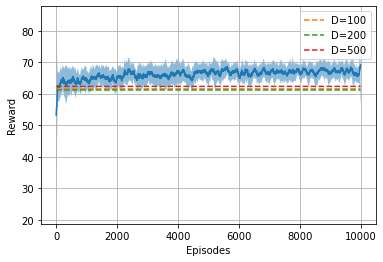

In [7]:
nepisodes_learning = 10000

x = np.arange(nepisodes_learning)
y = np.mean(uniform_filter1d(rewards_im0,size=100,mode='nearest',axis=1),axis=0)
ystd = np.std(uniform_filter1d(rewards_im0,size=100,mode='nearest'),axis=0)
plt.plot(x,y)
plt.fill_between(x,y-ystd,y+ystd,alpha=.5)
#plt.ylim(35,70)

# avg_rewards_im0 = []
# std_rewards_im0 = []
# for i in range(int(nepisodes_learning/100)):
#     avg_reward = np.mean(rewards_im0[:,i:((i+1)*100)-1])
#     std_reward = np.std(rewards_im0[:,i:((i+1)*100)-1])
#     avg_rewards_im0.append([avg_reward]*100)
#     std_rewards_im0.append([std_reward]*100)
# avg_rewards_im0 = [v for sl in avg_rewards_im0 for v in sl]
# std_rewards_im0 = [v for sl in std_rewards_im0 for v in sl]
# plt.plot(np.arange(nepisodes_learning),avg_rewards_im0, label='Standard RL')
# plt.fill_between(x,np.array(avg_rewards_im0)-np.array(std_rewards_im0),np.array(avg_rewards_im0)+np.array(std_rewards_im0),alpha=.5)

y = [np.mean(rewards_imN[:,0,:])]*(nepisodes_learning)
ystd = np.std(np.mean(rewards_imN[:,0,:],axis=1))
plt.plot(x,y, label='D=100', linestyle='dashed')
#plt.fill_between(x,y-ystd,y+ystd,alpha=.5)
print(ystd)

y = [np.mean(rewards_imN[:,1,:])]*(nepisodes_learning)
ystd = np.std(np.mean(rewards_imN[:,1,:],axis=1))
plt.plot(x,y, label='D=200', linestyle='dashed')
#plt.fill_between(x,y-ystd,y+ystd,alpha=.5)
print(ystd)

y = [np.mean(rewards_imN[:,2,:])]*(nepisodes_learning)
ystd = np.std(np.mean(rewards_imN[:,2,:],axis=1))
plt.plot(x,y, label='D=500', linestyle='dashed')
#plt.fill_between(x,y-ystd,y+ystd,alpha=.5)
print(ystd)

#plt.plot(np.arange(nepisodes_learning),avg_rewards_im0, label='Standard RL')
#plt.plot(np.arange(nepisodes_learning),[np.mean(rewards_imN[:,0,:])]*(nepisodes_learning), label='D=100', linestyle='dashed')
#plt.plot(np.arange(nepisodes_learning),[np.mean(rewards_imN[:,1,:])]*(nepisodes_learning), label='D=200', linestyle='dashed')
#plt.plot(np.arange(nepisodes_learning),[np.mean(rewards_imN[:,2,:])]*(nepisodes_learning), label='D=500', linestyle='dashed')

plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.legend()
plt.grid()

plt.savefig('simul5_imitation.png')
plt.show()